In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# from C_0B_eval import *
from C_0X_defs import *
from scipy.stats import sem, ttest_ind

In [6]:
def read_result_at(res_save_dir, epoch): 
    all_handler = DictResHandler(whole_res_dir=res_save_dir, 
                                 file_prefix=f"all-{epoch}")

    all_handler.read()

    return all_handler.res

def calculate_means_and_sems(values):
    """Calculates means and standard errors of the means (SEMs) for input values."""
    return np.mean(values), sem(values)

In [7]:
def plot_attention_epoch_trajectory(all_phi_type, all_attn, all_sepframes1, all_sepframes2, save_path): 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
    legend_namess = [['S-to-P', 'P-to-S', 'P-to-V', 'V-to-P'], ['#-to-P', 'P-to-#', 'P-to-V', 'V-to-P']]
    colors = ['b', 'g', 'red', 'orange']
    n_steps = 100
    segment_length = int(n_steps * 0.1)  # Calculate 20% segment length
    badcounts = {"ST": 0, "T": 0}
    totalcounts = {"ST": 0, "T": 0}

    for (selector, ax, legend_names) in zip(["ST", "T"], [ax1, ax2], legend_namess):
        # 这个只是处理ST和T，而非循环
        meanslist = []
        upperlist = []
        lowerlist = []
        for epoch in range(len(all_attn)): 
            # 循环每个epoch
            phi_type_epoch = all_phi_type[epoch]
            attn_epoch = all_attn[epoch]
            sepframes1_epoch = all_sepframes1[epoch]
            sepframes2_epoch = all_sepframes2[epoch]
            selected_tuples = [(sf1, sf2, attn) for pt, sf1, sf2, attn in zip(phi_type_epoch,  
                                                            sepframes1_epoch, 
                                                            sepframes2_epoch, 
                                                            attn_epoch) if pt == selector]
            selected_sf1s_epoch, selected_sf2s_epoch, selected_attns_epoch = zip(*selected_tuples)
            s_to_t_traj = []
            t_to_s_traj = []
            t_to_a_traj = []
            a_to_t_traj = []

            totalcounts[selector] += len(selected_attns_epoch)
        
            for i in range(len(selected_attns_epoch)): 
                # 循环每个run
                this_attn = selected_attns_epoch[i]
                # this_sep_frame0 = selected_sf0s_epoch[i]
                this_sep_frame1 = selected_sf1s_epoch[i]
                this_sep_frame2 = selected_sf2s_epoch[i]

                if selector == "ST": 
                    blocks = extract_attention_blocks_ST(this_attn, this_sep_frame1, this_sep_frame2)
                elif selector == "T": 
                    blocks = extract_attention_blocks_ST(this_attn, this_sep_frame1, this_sep_frame2)
                else: 
                    raise ValueError("selector must be ST or T")

                s_to_t_interp = blocks['s_to_t']
                t_to_s_interp = blocks['t_to_s']
                t_to_a_interp = blocks['t_to_a']
                a_to_t_interp = blocks['a_to_t']

                if np.any(np.isnan(s_to_t_interp)) or np.any(np.isnan(t_to_s_interp)) or np.any(np.isnan(t_to_a_interp)) or np.any(np.isnan(a_to_t_interp)):
                    badcounts[selector] += 1
                    # print(f"NAN at {epoch} in run {i} for {selector}")
                    continue
                s_to_t_traj.append(s_to_t_interp[-1])
                t_to_s_traj.append(t_to_s_interp[0])
                t_to_a_traj.append(t_to_a_interp[-1])
                a_to_t_traj.append(a_to_t_interp[0])

            # Convert list of arrays into 2D NumPy arrays for easier manipulation
            group1_array = np.array(s_to_t_traj)
            group2_array = np.array(t_to_s_traj)
            group3_array = np.array(t_to_a_traj)
            group4_array = np.array(a_to_t_traj)

            target_group1 = group1_array.flatten()
            target_group2 = group2_array.flatten()
            target_group3 = group3_array.flatten()
            target_group4 = group4_array.flatten()

            # Calculate the mean trajectory for each group
            means = np.array([np.mean(target_group1, axis=0), 
                            np.mean(target_group2, axis=0), 
                            np.mean(target_group3, axis=0), 
                            np.mean(target_group4, axis=0)])

            # Calculate the SEM for each step in both groups
            sems = np.array([sem(target_group1, axis=0),
                            sem(target_group2, axis=0),
                            sem(target_group3, axis=0),
                            sem(target_group4, axis=0)])

            # Calculate the 95% CI for both groups
            ci_95s = 1.96 * sems

            # Upper and lower bounds of the 95% CI for both groups
            upper_bounds = means + ci_95s
            lower_bounds = means - ci_95s

            meanslist.append(means)
            upperlist.append(upper_bounds)
            lowerlist.append(lower_bounds)

        means = np.array(meanslist)
        upper_bounds = np.array(upperlist)
        lower_bounds = np.array(lowerlist)
        means = means.T
        upper_bounds = upper_bounds.T
        lower_bounds = lower_bounds.T
        print(means.shape, upper_bounds.shape, lower_bounds.shape)
        num_epochs = 100
        for mean, upper, lower, label, c in zip(means, upper_bounds, lower_bounds, legend_names, colors):
            ax.plot(mean, label=label, color=c)
            ax.fill_between(range(len(mean)), lower, upper, alpha=0.2, color=c)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Summed Foreign-Attention')
        ax.set_title(f'{selector}')
        ax.set_ylim([0, 0.8])
        ax.legend(loc = "upper right")
        ax.grid(True)

    print(f"badcounts: {badcounts}")
    print(f"totalcounts: {totalcounts}")
    # fig.suptitle('Comparison of Foreign-Attention Trajectory')
    plt.tight_layout()
    # plt.show()
    plt.savefig(save_path)
    plt.close()

In [8]:
def plot_attention_epoch_trajectory_onedim(ax1, ax2, all_phi_type, all_attn, all_sepframes1, all_sepframes2, plot_subtitle=False, toptick=False, subsubtitle=""): 
    legend_namess = [['S-to-P', 'P-to-S', 'P-to-V', 'V-to-P'], ['#-to-P', 'P-to-#', 'P-to-V', 'V-to-P']]
    colors = ['b', 'g', 'red', 'orange']
    n_steps = 100
    segment_length = int(n_steps * 0.1)  # Calculate 20% segment length
    badcounts = {"ST": 0, "T": 0}
    totalcounts = {"ST": 0, "T": 0}

    for (selector, ax, legend_names) in zip(["ST", "T"], [ax1, ax2], legend_namess):
        # 这个只是处理ST和T，而非循环
        meanslist = []
        upperlist = []
        lowerlist = []
        for epoch in range(len(all_attn)): 
            # 循环每个epoch
            phi_type_epoch = all_phi_type[epoch]
            attn_epoch = all_attn[epoch]
            sepframes1_epoch = all_sepframes1[epoch]
            sepframes2_epoch = all_sepframes2[epoch]
            selected_tuples = [(sf1, sf2, attn) for pt, sf1, sf2, attn in zip(phi_type_epoch,  
                                                            sepframes1_epoch, 
                                                            sepframes2_epoch, 
                                                            attn_epoch) if pt == selector]
            selected_sf1s_epoch, selected_sf2s_epoch, selected_attns_epoch = zip(*selected_tuples)
            s_to_t_traj = []
            t_to_s_traj = []
            t_to_a_traj = []
            a_to_t_traj = []

            totalcounts[selector] += len(selected_attns_epoch)
        
            for i in range(len(selected_attns_epoch)): 
                # 循环每个run
                this_attn = selected_attns_epoch[i]
                # this_sep_frame0 = selected_sf0s_epoch[i]
                this_sep_frame1 = selected_sf1s_epoch[i]
                this_sep_frame2 = selected_sf2s_epoch[i]

                if selector == "ST": 
                    blocks = extract_attention_blocks_ST(this_attn, this_sep_frame1, this_sep_frame2)
                elif selector == "T": 
                    blocks = extract_attention_blocks_ST(this_attn, this_sep_frame1, this_sep_frame2)
                else: 
                    raise ValueError("selector must be ST or T")

                s_to_t_interp = blocks['s_to_t']
                t_to_s_interp = blocks['t_to_s']
                t_to_a_interp = blocks['t_to_a']
                a_to_t_interp = blocks['a_to_t']

                if np.any(np.isnan(s_to_t_interp)) or np.any(np.isnan(t_to_s_interp)) or np.any(np.isnan(t_to_a_interp)) or np.any(np.isnan(a_to_t_interp)):
                    badcounts[selector] += 1
                    # print(f"NAN at {epoch} in run {i} for {selector}")
                    continue
                s_to_t_traj.append(s_to_t_interp[-1])
                t_to_s_traj.append(t_to_s_interp[0])
                t_to_a_traj.append(t_to_a_interp[-1])
                a_to_t_traj.append(a_to_t_interp[0])

            # Convert list of arrays into 2D NumPy arrays for easier manipulation
            group1_array = np.array(s_to_t_traj)
            group2_array = np.array(t_to_s_traj)
            group3_array = np.array(t_to_a_traj)
            group4_array = np.array(a_to_t_traj)

            target_group1 = group1_array.flatten()
            target_group2 = group2_array.flatten()
            target_group3 = group3_array.flatten()
            target_group4 = group4_array.flatten()

            # Calculate the mean trajectory for each group
            means = np.array([np.mean(target_group1, axis=0), 
                            np.mean(target_group2, axis=0), 
                            np.mean(target_group3, axis=0), 
                            np.mean(target_group4, axis=0)])

            # Calculate the SEM for each step in both groups
            sems = np.array([sem(target_group1, axis=0),
                            sem(target_group2, axis=0),
                            sem(target_group3, axis=0),
                            sem(target_group4, axis=0)])

            # Calculate the 95% CI for both groups
            ci_95s = 1.96 * sems

            # Upper and lower bounds of the 95% CI for both groups
            upper_bounds = means + ci_95s
            lower_bounds = means - ci_95s

            meanslist.append(means)
            upperlist.append(upper_bounds)
            lowerlist.append(lower_bounds)

        means = np.array(meanslist)
        upper_bounds = np.array(upperlist)
        lower_bounds = np.array(lowerlist)
        means = means.T
        upper_bounds = upper_bounds.T
        lower_bounds = lower_bounds.T
        print(means.shape, upper_bounds.shape, lower_bounds.shape)
        num_epochs = 100
        for mean, upper, lower, label, c in zip(means, upper_bounds, lower_bounds, legend_names, colors):
            ax.plot(mean, label=label, color=c)
            ax.fill_between(range(len(mean)), lower, upper, alpha=0.2, color=c)
        
        if plot_subtitle: 
            subtitle = "sPV" if selector == "ST" else "#PV"
            ax.set_title(f"{subtitle}", fontdict={"fontsize": 48})
        if toptick:
            ax.xaxis.set_ticks_position('top')

        labels = ax.get_xticklabels() + ax.get_yticklabels()
        [label.set_fontsize(36) for label in labels]
        ax.set_ylim([0, 0.8])
        ax.grid(True)
    
    ax2.set_ylabel(f'{subsubtitle}', fontdict={"fontsize": 48})

    
    print(f"badcounts: {badcounts}")
    print(f"totalcounts: {totalcounts}")
    # fig.suptitle('Comparison of Foreign-Attention Trajectory')
    # plt.tight_layout()
    # plt.show()
    # plt.savefig(save_path)
    # plt.close()

In [9]:
ts = "0611193546" # this timestamp does not contain run number
model_condition = "u"
train_name = "C_0T"
res_save_dir = os.path.join(model_save_, f"eval-{train_name}-{ts}")

alldimresdict = {}
for model_type in ['recon4-phi', 'recon8-phi', 'recon16-phi', 'recon32-phi']: 
    num_dim = int(model_type.split("-")[0].split("recon")[1])
    model_condition_dir = os.path.join(res_save_dir, model_type, model_condition)
    assert PU.path_exist(model_condition_dir)
    this_save_dir = os.path.join(model_condition_dir, "integrated_results")
    mk(this_save_dir)

    every_attns = []
    # every_sepframes0 = []
    every_sepframes1 = []
    every_sepframes2 = []
    every_phi_types = []

    learned_runs = [1, 2, 3, 4, 5]
    string_learned_runs = [str(num) for num in learned_runs]
    strseq_learned_runs = "".join(string_learned_runs)

    for epoch in range(0, 100): 
        cat_attns = []
        # cat_sepframes0 = []
        cat_sepframes1 = []
        cat_sepframes2 = []
        cat_phi_types = []
        print(f"Processing {model_type} at {epoch}...")

        for run_number in learned_runs:
            this_model_condition_dir = os.path.join(model_condition_dir, f"{run_number}")
            allres = read_result_at(this_model_condition_dir, epoch)
            cat_phi_types += allres["phi-type"]
            cat_attns += allres["attn"]
            # cat_sepframes0 += allres["sep-frame0"]
            cat_sepframes1 += allres["sep-frame1"]
            cat_sepframes2 += allres["sep-frame2"]

        every_attns.append(cat_attns)
        every_sepframes1.append(cat_sepframes1)
        every_sepframes2.append(cat_sepframes2)
        every_phi_types.append(cat_phi_types)
    this_res_dict = {
        "attn": every_attns, 
        "sep-frame1": every_sepframes1, 
        "sep-frame2": every_sepframes2, 
        "phi-type": every_phi_types, 
        "name": f"dim = {num_dim}"
    }
    alldimresdict[model_type] = this_res_dict
    # plot_attention_epoch_trajectory(every_phi_types, every_attns, every_sepframes1, every_sepframes2, os.path.join(res_save_dir, f"attnepochtraj-at-all-{model_type}-{model_condition}-{strseq_learned_runs}-10pc.png"))

    print("Done dimension ", num_dim)

Processing recon4-phi at 0...
Processing recon4-phi at 1...
Processing recon4-phi at 2...
Processing recon4-phi at 3...
Processing recon4-phi at 4...
Processing recon4-phi at 5...
Processing recon4-phi at 6...
Processing recon4-phi at 7...
Processing recon4-phi at 8...
Processing recon4-phi at 9...
Processing recon4-phi at 10...
Processing recon4-phi at 11...
Processing recon4-phi at 12...
Processing recon4-phi at 13...
Processing recon4-phi at 14...
Processing recon4-phi at 15...
Processing recon4-phi at 16...
Processing recon4-phi at 17...
Processing recon4-phi at 18...
Processing recon4-phi at 19...
Processing recon4-phi at 20...
Processing recon4-phi at 21...
Processing recon4-phi at 22...
Processing recon4-phi at 23...
Processing recon4-phi at 24...
Processing recon4-phi at 25...
Processing recon4-phi at 26...
Processing recon4-phi at 27...
Processing recon4-phi at 28...
Processing recon4-phi at 29...
Processing recon4-phi at 30...
Processing recon4-phi at 31...
Processing recon4-

In [10]:
alldimresdict["recon4-phi"]["name"]

'dim = 4'

In [11]:
things_save_dir = res_save_dir + "posterplot/"
mk(things_save_dir)

In [12]:
import matplotlib.patches as mpatches
# plt.figure(dpi=300)
fig, axs = plt.subplots(4, 2, figsize=(32, 24), sharex=True, sharey=True, dpi=300)
for i, (model_type, datadict) in enumerate(alldimresdict.items()): 
    ax1 = axs[i, 0]
    ax2 = axs[i, 1]
    plot_attention_epoch_trajectory_onedim(ax1, ax2, datadict["phi-type"], datadict["attn"], datadict["sep-frame1"], datadict["sep-frame2"], plot_subtitle=(i==0), toptick=False, subsubtitle=datadict["name"])
    # plot_attention_epoch_trajectory_onedim(axs[0, num_dim // 8 - 1], axs[1, num_dim // 8 - 1], datadict["phi-type"], datadict["attn"], datadict["sep-frame1"], datadict["sep-frame2"], plot_subtitle=True, toptick=True)
    print(f"Done plotting {model_type}")

# fig.text(0.25, 1.06, f"dim = 4\ndim = 8", ha='center', fontsize=56)
fig.text(0.5, -0.01, f"Epochs", ha='center', fontsize=48)
fig.text(1.01, 0.5, f"Summed Foreign-Attention", ha='center', va="center", fontsize=48, rotation=270)

# legend_namess = [['S-to-P', 'P-to-S', 'P-to-V', 'V-to-P'], ['#-to-P', 'P-to-#', 'P-to-V', 'V-to-P']]
# colors = ['b', 'g', 'red', 'orange']

# s2p = mpatches.Patch(color='b', label='S/#-to-P')
# p2s = mpatches.Patch(color='g', label='P-to-S/#')
# p2v = mpatches.Patch(color='red', label='P-to-V')
# v2p = mpatches.Patch(color='orange', label='V-to-P')

# plt.legend(handles=[red_patch, blue_patch])
# fig.legend(handles=[s2p, p2s, p2v, v2p], loc="upper center", fontsize=48, ncol=2)
plt.tight_layout()  # leave space for subtitles
# plt.subplots_adjust(wspace=0, hspace=0.1)  # remove space between subplots
plt.show()
# plt.savefig(os.path.join(things_save_dir, f"attnepochtraj-all-all-{strseq_learned_runs}-1.png"), dpi=300)

(4, 100) (4, 100) (4, 100)
(4, 100) (4, 100) (4, 100)
badcounts: {'ST': 0, 'T': 0}
totalcounts: {'ST': 235200, 'T': 235200}
Done plotting recon4-phi
(4, 100) (4, 100) (4, 100)
(4, 100) (4, 100) (4, 100)
badcounts: {'ST': 0, 'T': 0}
totalcounts: {'ST': 235200, 'T': 235200}
Done plotting recon8-phi
(4, 100) (4, 100) (4, 100)
(4, 100) (4, 100) (4, 100)
badcounts: {'ST': 0, 'T': 0}
totalcounts: {'ST': 235200, 'T': 235200}
Done plotting recon16-phi
(4, 100) (4, 100) (4, 100)
(4, 100) (4, 100) (4, 100)
badcounts: {'ST': 0, 'T': 0}
totalcounts: {'ST': 235200, 'T': 235200}
Done plotting recon32-phi


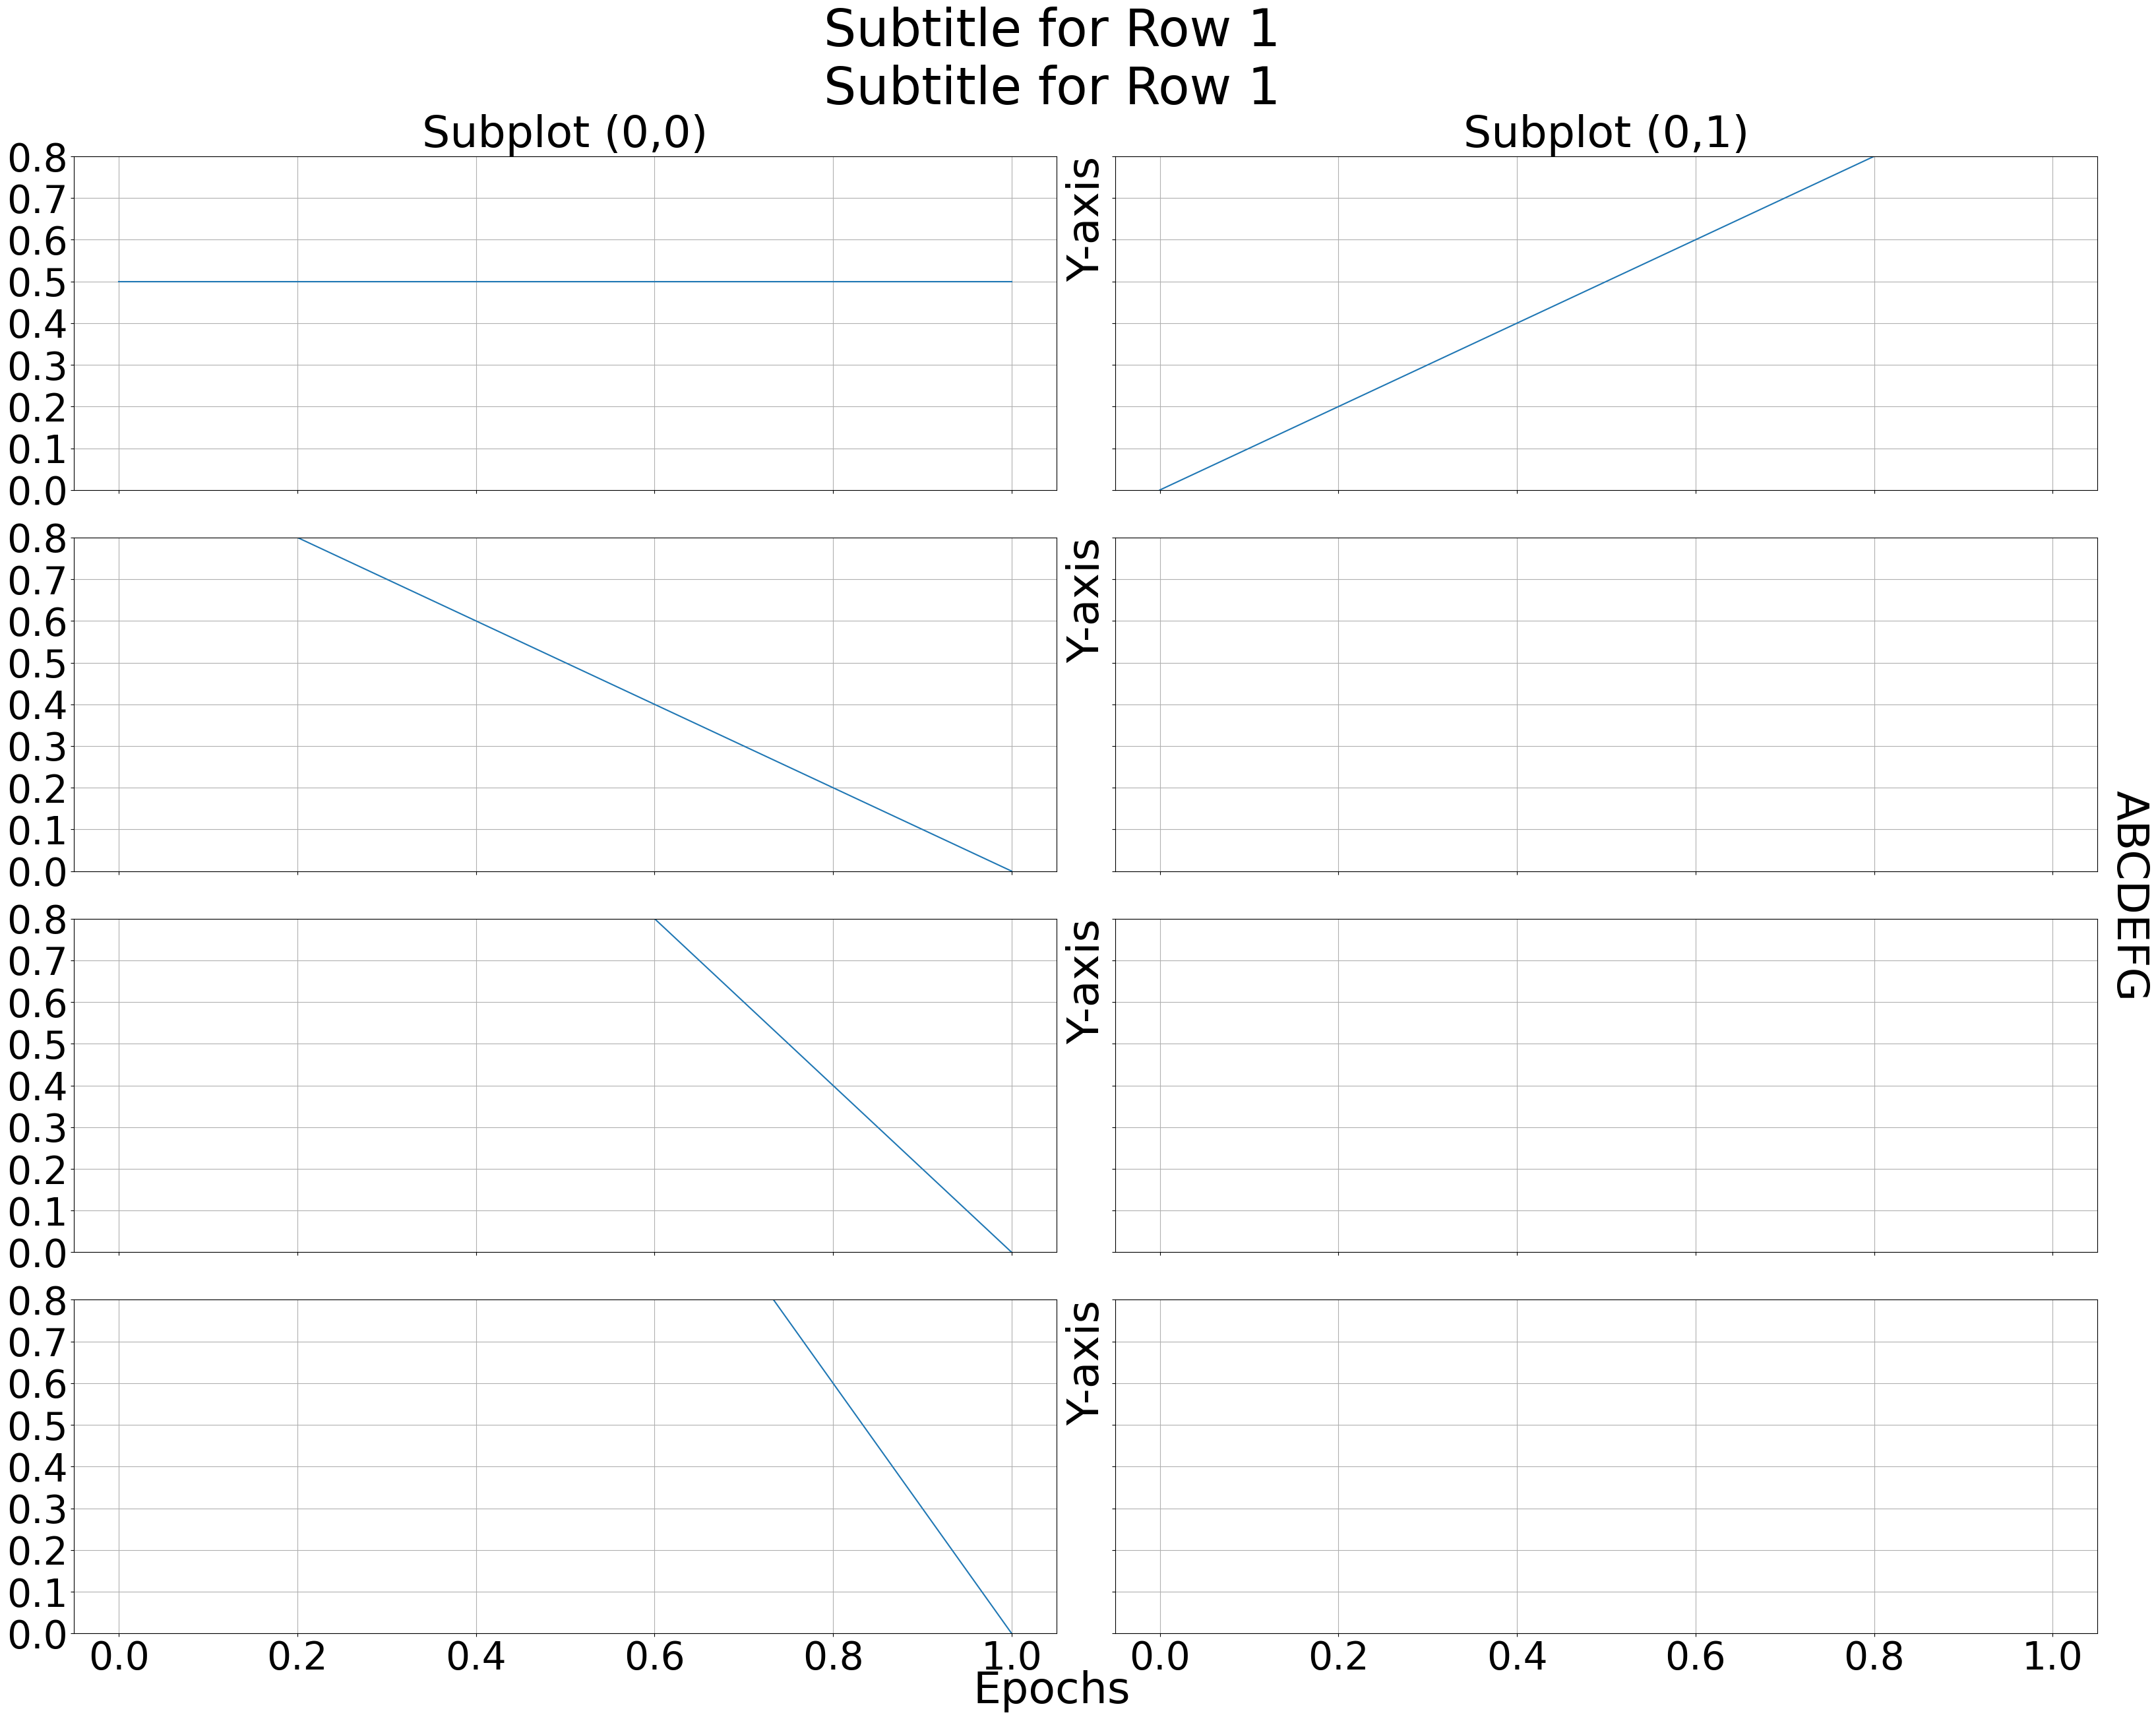

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create a figure and a 4x2 grid of subplots
fig, axs = plt.subplots(4, 2, figsize=(32, 24), sharex=True, sharey=True)

# Loop over each subplot
for i in range(4):
    for j in range(2):
        ax = axs[i, j]
        ax.grid(True)
        # Plot example data
        if i == 0 and j == 0: 
            ax.plot([0, 1], [0.5, 0.5])
        else: 
            ax.plot([0, 1], [i, j])
        if i == 0: 
            ax.set_title(f"Subplot ({i},{j})", fontdict={"fontsize": 48})
            # if j == 0: 
            #     ax.legend(loc="upper left")
        if j == 1: 
            ax.set_ylabel("Y-axis", fontdict={"fontsize": 48}, loc="top")
        # elif i == 1: 
        #     ax.xaxis.set_ticks_position('top')
        labels = ax.get_xticklabels() + ax.get_yticklabels()
        [label.set_fontsize(42) for label in labels]
        ax.set_ylim([0, 0.8])

# # Add subtitles above each row
# for i in range(4):
fig.text(0.5, 1, f"Subtitle for Row {1}\nSubtitle for Row {1}", ha='center', fontsize=56)
fig.text(0.5, -0.01, f"Epochs", ha='center', fontsize=48)
fig.text(1.01, 0.5, f"ABCDEFG", ha='center', va="center", fontsize=48, rotation=270)
# fig.text(0.25, 0, f"Subtitle for Row {2}", ha='center', fontsize=16)
# plt.figtext(0.5, 0.95, "Comparison of Foreign-Attention Trajectory", ha='center', va='center', fontdict=font)
# Adjust layout to prevent overlap
red_patch = mpatches.Patch(color='red', label='The red data')
blue_patch = mpatches.Patch(color='blue', label='The blue data')
green_patch = mpatches.Patch(color='green', label='The green data')
orange_patch = mpatches.Patch(color='orange', label='The orange data')

# plt.legend(handles=[red_patch, blue_patch])
# fig.legend(handles=[red_patch, blue_patch, green_patch, orange_patch], loc="upper center", fontsize=48, ncol=2)
plt.tight_layout()  # leave space for subtitles
# plt.subplots_adjust(wspace=0, hspace=0.1)  # remove space between subplots
plt.show()
# plt.savefig(os.path.join(things_save_dir, f"attnepochtraj-all-all-{strseq_learned_runs}-1.png"), dpi=1200)